In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.circuit.library.standard_gates import CRYGate
from qiskit.circuit.library.standard_gates import CHGate
from qiskit.circuit.library.standard_gates import HGate
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit.library.standard_gates import RZGate

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
def Bx():
    temp = QuantumCircuit(2)
    temp.append(RXGate(-np.pi/2), [0])
    temp.append(RXGate(-np.pi/2), [1])
    return temp

In [5]:
def By():
    temp = QuantumCircuit(2)
    temp.append(RYGate(-np.pi/2), [0])
    temp.append(RYGate(-np.pi/2), [1])
    return temp

In [6]:
def Bz():
    temp = QuantumCircuit(2)
    temp.append(RZGate(-np.pi/2), [0])
    temp.append(RZGate(-np.pi/2), [1])
    return temp

In [7]:
def Bxb():
    temp = QuantumCircuit(2)
    temp.append(RXGate(np.pi/2), [0])
    temp.append(RXGate(np.pi/2), [1])
    return temp

In [8]:
def Byb():
    return By()

In [9]:
def Bzb():
    temp = QuantumCircuit(2)
    temp.append(RZGate(np.pi/2), [0])
    temp.append(RZGate(np.pi/2), [1])
    return temp

In [10]:
numLayer = 3
numQubit = 3
global iterations
global noisy

In [11]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 8):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

unitary_param_1 = [4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712,
                   3.44120060, 3.24526326]

In [12]:
print(unitary_param_1)

[4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712, 3.4412006, 3.24526326]


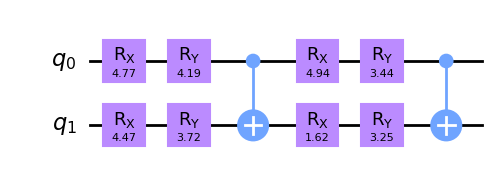

In [13]:
# First unitary
size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [14]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [15]:
def createEqSuperposCollectiveUSE():
    temp = QuantumCircuit(5)
    
    temp.ry(2*np.arctan(1/np.sqrt(2)), 1)
    temp.x(1)
    temp.append(CHGate(), [1, 0])
    temp.x(1)
    
    temp.ry(np.pi/3, 2)
    temp.x(2)
    temp.append(CRYGate(2*np.arctan(1/np.sqrt(2))), [2, 3])
    temp.x(3)
    temp.append(HGate().control(2), [2, 3, 4])
    temp.x(2)
    temp.x(3)
    return temp

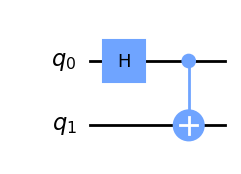

In [52]:
qcTest = QuantumCircuit(2)
qcTest.h(0)
qcTest.cx(0, 1)
qcTest.draw('mpl')

In [53]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(9)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposCollectiveUSE()
    circ.append(superPosCircuit, [0, 1, 2, 3, 4])

    circ.append(state, [5, 6])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [6, 7, 8])
    
    circ.append(Bx().control(1), [4, 5, 6])
    circ.append(Bxb().control(1), [4, 7, 8])
    circ.append(Bx().control(1), [4, 5, 6])
    circ.append(Bxb().control(1), [4, 7, 8])
    
    circ.append(By().control(1), [3, 5, 6])
    circ.append(Byb().control(1), [3, 7, 8])
    circ.append(By().control(1), [3, 5, 6])
    circ.append(Byb().control(1), [3, 7, 8])

    circ.append(Bz().control(1), [2, 5, 6])
    circ.append(Bzb().control(1), [2, 7, 8])
    circ.append(Bz().control(1), [2, 5, 6])
    circ.append(Bzb().control(1), [2, 7, 8])
    
    circ.append(By().control(1), [1, 5, 6])
    circ.append(Byb().control(1), [1, 7, 8])
    circ.append(Bx().control(1), [1, 5, 6])
    circ.append(Bxb().control(1), [1, 7, 8])
    
    circ.append(Bx().control(1), [0, 5, 6])
    circ.append(Bxb().control(1), [0, 7, 8])
    circ.append(By().control(1), [0, 5, 6])
    circ.append(Byb().control(1), [0, 7, 8])
    
    circ.append(superPosCircuit.inverse(), [0, 1, 2, 3, 4])
    
    return circ

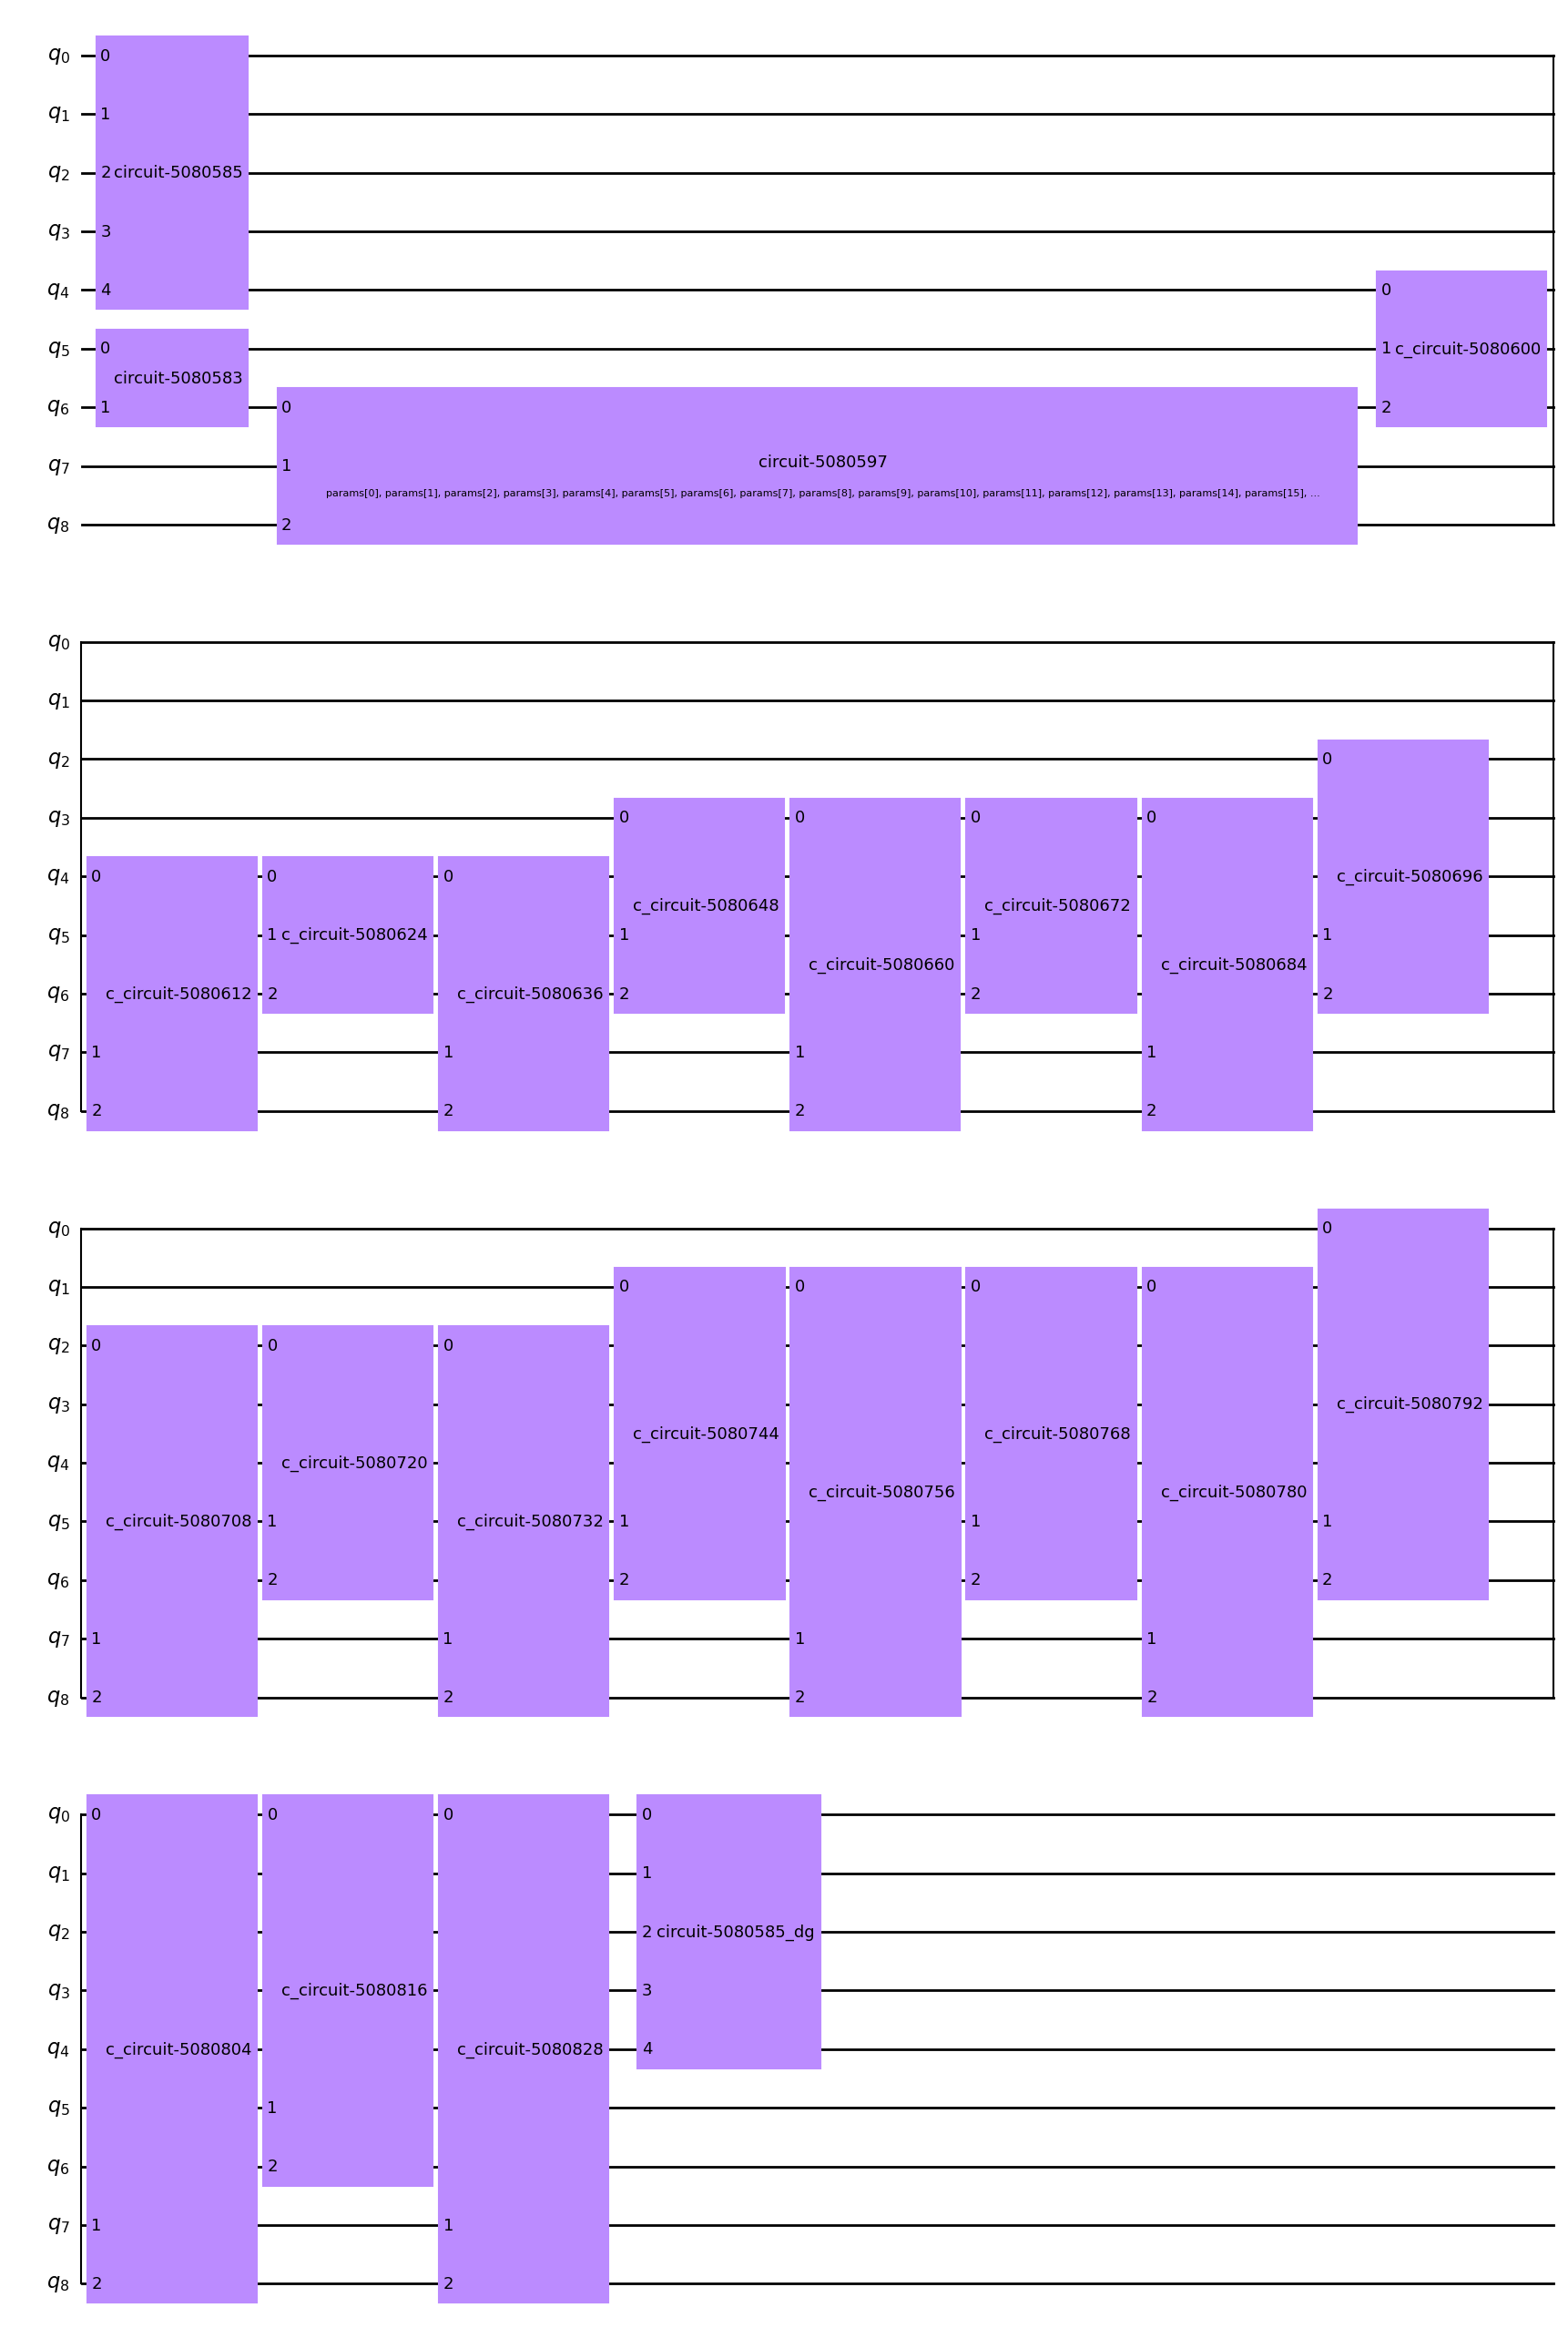

In [54]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [55]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [56]:
#Use if noisy
provider = IBMQ.get_provider(hub='ibm-q')
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [57]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [58]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [59]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [60]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17])])


In [61]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [63]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[0.06785471 5.77450996 4.22538325 0.0925012  0.23053805 0.8384788
 2.0540719  3.11642858 6.03168712 6.07843024 4.08335335 4.86270586
 4.84595441 2.77875246 1.97816354 6.01678402 4.6852677  4.60791737]
Initial Cost :  0.18766565731072202


In [64]:
true_value = 1.0

In [65]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.18766565731072202
Loss Value :  0.18182814979289286 1.0%
Loss Value :  0.05037843838028271 2.0%
Loss Value :  0.21492918993732404 3.0%
Loss Value :  0.2262344453444496 4.0%
Loss Value :  0.25582895749691237 5.0%
Loss Value :  0.25695307955468205 6.0%
Loss Value :  0.2496923253981896 7.0%
Loss Value :  0.2608546504020087 8.0%
Loss Value :  0.27143046147763594 9.0%
Loss Value :  0.4635263657090555 10.0%
Loss Value :  0.3686174581459498 11.0%
Loss Value :  0.23889894613739854 12.0%
Loss Value :  0.22588292268022206 13.0%
Loss Value :  0.35327965347416723 14.0%
Loss Value :  0.2994912839478481 15.0%
Loss Value :  0.37712685097792664 16.0%
Loss Value :  0.41686720210780204 17.0%
Loss Value :  0.4012091021958623 18.0%
Loss Value :  0.1538336411678537 19.0%
Loss Value :  0.260428798747566 20.0%
Loss Value :  0.3590119440166196 21.0%
Loss Value :  0.36907111057393205 22.0%
Loss Value :  0.37045278097890466 23.0%
Loss Value :  0.41334397601521655 24.0%
Loss Value :  0.45603883

In [66]:
#noisy = True
#noisy_loss = []
#noisyParam = np.copy(paramProver)
#-1*costf(noisyParam)
#print("Initial Cost : ", -1*costf(noisyParam))
#autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
#x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

In [67]:
#noisy = False
#noiseResilientValue = -1*costf(x_opt)
#print(noiseResilientValue)

In [68]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
#print("Noisy : ", noisy_loss[-1])
#print("Noise Resilient Value : ", noiseResilientValue)

True Value :  1.0
Noiseless :  0.9995824459021113


In [33]:
def writeToFile():
    file = open("CU_GSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(true_value)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss[0:len(noiseless_loss)-1]]
    file.writelines(L)
    
    file.write(str(noiseless_loss[-1]))
    
    file.close()

In [34]:
writeToFile()